In [1]:
import gym
from gym_minigrid.wrappers import ImgObsWrapper
from mini_behavior.utils.wrappers import MiniBHFullyObsWrapper
from mini_behavior.register import register
from algorithms.APT_PPO import APT_PPO
import mini_behavior
from stable_baselines3 import PPO
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
import torch.nn as nn
import torch
from env_wrapper import CustomObservationWrapper
import argparse

class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.Space, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

TASK = 'MultiToy'
PARTIAL_OBS = True
ROOM_SIZE = 10
MAX_STEPS = 1000
TOTAL_TIMESTEPS = 1e5
DENSE_REWARD = False
POLICY_TYPE = 'CnnPolicy'
NUM_ENVS = 8
NUM_STEPS = 125
env_name = f"MiniGrid-{TASK}-{ROOM_SIZE}x{ROOM_SIZE}-N2-v0"

In [2]:
env_kwargs = {"room_size": ROOM_SIZE, "max_steps": MAX_STEPS, "exploration_type": "ATP"}
def get_single_env() -> gym.Env:
    '''
    policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128)
)
    '''

    # Env wrapping
    env_name = f"MiniGrid-{TASK}-{ROOM_SIZE}x{ROOM_SIZE}-N2-v0"

    kwargs = {"room_size": ROOM_SIZE, "max_steps": MAX_STEPS}


    register(
        id=env_name,
        entry_point=f'mini_behavior.envs:{TASK}Env',
        kwargs=kwargs
    )

    '''
    config = {
        "policy_type": POLICY_TYPE,
        "total_timesteps": TOTAL_TIMESTEPS,
        "env_name": env_name,
    }
    '''
    
    env = gym.make(env_name)
    env = CustomObservationWrapper(env)

    return env


def init_env(num_envs: int):

    env_fns = [lambda: get_single_env() for _ in range(num_envs)]
    if num_envs == 1:
        return DummyVecEnv(env_fns)
    else:
        return SubprocVecEnv(env_fns)
    




In [3]:
env = get_single_env()


=== Observation Space ===
Shape: (59,)
Type: float32


In [27]:
print(env.gen_obs())
objs_dict = {}
for obj_type in env.objs.values():
    for obj in obj_type:
        states_dict = {}
        for state_value in obj.states:
            if not isinstance(obj.states[state_value], RelativeObjectState):
                state = obj.states[state_value].get_value(env)
                states_dict[state_value] = state
        objs_dict[obj.name] = states_dict
print(objs_dict)
                

[5. 6. 0. 3. 3. 0. 0. 0. 0. 1. 7. 0. 0. 0. 3. 2. 0. 0. 0. 4. 1. 0. 0. 0.
 0. 0. 6. 4. 1. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0. 0. 0. 8. 6. 1. 0. 0. 0. 3.
 5. 0. 0. 0. 2. 6. 0. 0. 0. 0. 0.]
{'alligator_busy_box_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False, 'toggled': False}, 'ball_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False}, 'beach_ball_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False}, 'music_toy_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False, 'noise': False, 'toggled': False}, 'farm_toy_0': {'infovofrobot': True, 'inhandofrobot': False, 'inreachofrobot': False, 'popup': False, 'toggled': False}, 'piggie_bank_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False, 'noise': False, 'open': False, 'toggled': False}, 'rattle_0': {'infovofrobot': True, 'inhandofrobot': False, 'inreachofrobot': False, 'noise': False}, 'red_spiky_ball_0': {'infovofrobot': False,

In [25]:
from mini_behavior.utils.states_base import RelativeObjectState
print(env.objs)
for obj_type in env.objs.values():
    for obj in obj_type:
        print(obj.name, end = '\n\n')
        for state_value in obj.states:
            if not isinstance(obj.states[state_value], RelativeObjectState):
                state = obj.states[state_value].get_value(env)
                print(str(state_value) + ": " + str(state))

exploration_dict = {obj.name: {} for obj_type in env.objs.values() for obj in obj_type}
for dict, obj in zip(exploration_dict.values(), list(obj for obj_type in env.objs.values() for obj in obj_type)):
    for state_value in obj.states:
        if not isinstance(obj.states[state_value], RelativeObjectState):
            dict[state_value] = 0
print(exploration_dict)


{'alligator_busy_box': [<mini_behavior.utils.objects_base.WorldObj object at 0x1059ae8e0>], 'ball': [<mini_behavior.utils.objects_base.WorldObj object at 0x1059ae610>], 'beach_ball': [<mini_behavior.utils.objects_base.WorldObj object at 0x1059aefa0>], 'music_toy': [<mini_behavior.utils.objects_base.WorldObj object at 0x105937670>], 'farm_toy': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f78fe20>], 'piggie_bank': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f78ffd0>], 'rattle': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f78fcd0>], 'red_spiky_ball': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f7915e0>], 'winnie_cabinet': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f791820>]}
alligator_busy_box_0

infovofrobot: False
inhandofrobot: False
inreachofrobot: False
toggled: False
ball_0

infovofrobot: False
inhandofrobot: False
inreachofrobot: False
beach_ball_0

infovofrobot: False
inhandofrobot: False
inreachofrobot: False


In [ ]:
env = init_env(NUM_ENVS)
    
print('begin training')
# Policy training
model = APT_PPO(env, num_envs=NUM_ENVS, total_timesteps = TOTAL_TIMESTEPS, num_steps=NUM_STEPS, save_freq = 10)

model.train()

In [4]:
import os

# Define the directory path
save_dir = "models/ATP_PPO_Trial"

# Check if the directory exists, and if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model.save(f"{save_dir}/{env_name}", env_kwargs= env_kwargs)

In [5]:
checkpoint = torch.load("/Users/kevinhan/mini_behavior/models/ATP_PPO_Trial/MiniGrid-PlayAlligator-10x10-N2-v0")

In [6]:
print(checkpoint.keys())

dict_keys(['env_kwargs', 'model_saves', 'final_model_state_dict', 'final_optimizer_state_dict', 'learning_rate', 'total_timesteps', 'num_envs', 'num_steps', 'curiosity_rewards', 'actions', 'observations'])


In [7]:
print(checkpoint['env_kwargs'])


{'room_size': 10, 'max_steps': 1000, 'exploration_type': 'ATP'}


In [9]:
print(checkpoint['observations'][0][0])


tensor([[4., 7., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
        [1., 7., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
        [6., 8., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
        [3., 8., 3., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
        [5., 5., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
        [5., 7., 3., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.],
        [4., 8., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
        [5., 7., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.]])


In [8]:
print(rewards)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8b4849dd60>>
Traceback (most recent call last):
  File "/Users/kevinhan/opt/anaconda3/envs/babyRL/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


NameError: name 'rewards' is not defined

In [41]:
support_cache = supports(armies)

In [42]:
print(support_cache)

{'B': 1, 'C': 1, 'D': 1}


In [13]:
from numpy import linalg as LA
p1, p2 = np.array([0, 0]), np.array([4, 4])
dp = LA.norm((p1 - p2))
print(np.sqrt(32))
print(dp)

5.656854249492381
5.656854249492381


In [32]:
test_dict = {"one": 1, "two": 2}

for i,j in zip(test_dict.keys(), test_dict.values()):
    print(i,j)

one 1
two 2


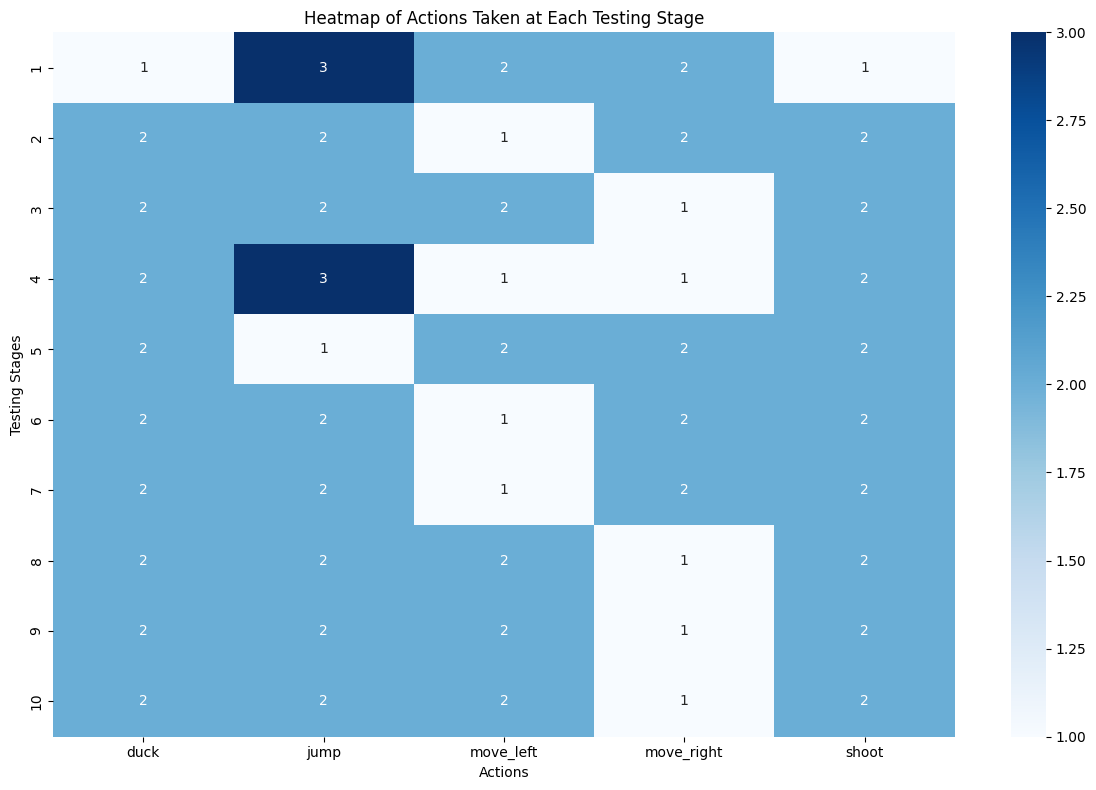

In [46]:
test_actions = [
    ['move_left', 'move_right', 'jump', 'duck', 'move_left', 'jump', 'shoot', 'jump', 'move_right'],  # Stage 1
    ['move_right', 'duck', 'jump', 'jump', 'move_left', 'shoot', 'duck', 'move_right', 'shoot'],      # Stage 2
    ['move_left', 'move_right', 'shoot', 'duck', 'duck', 'jump', 'move_left', 'jump', 'shoot'],      # Stage 3
    ['jump', 'jump', 'move_left', 'move_right', 'shoot', 'shoot', 'duck', 'duck', 'jump'],           # Stage 4
    ['move_left', 'move_right', 'shoot', 'duck', 'jump', 'move_right', 'move_left', 'duck', 'shoot'],# Stage 5
    ['duck', 'move_right', 'move_right', 'jump', 'shoot', 'move_left', 'jump', 'shoot', 'duck'],     # Stage 6
    ['jump', 'move_left', 'shoot', 'duck', 'jump', 'move_right', 'duck', 'move_right', 'shoot'],     # Stage 7
    ['move_left', 'duck', 'jump', 'move_right', 'shoot', 'jump', 'move_left', 'shoot', 'duck'],      # Stage 8
    ['shoot', 'move_right', 'duck', 'move_left', 'jump', 'shoot', 'duck', 'move_left', 'jump'],      # Stage 9
    ['jump', 'shoot', 'duck', 'move_left', 'move_right', 'move_left', 'jump', 'shoot', 'duck']       # Stage 10
]


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a DataFrame of action counts per stage
unique_actions = sorted(set(action for actions in test_actions for action in actions))
data = pd.DataFrame(0, index=range(1, len(test_actions) + 1), columns=unique_actions)

# Populate the DataFrame with counts
for i, actions in enumerate(test_actions):
    for action in actions:
        data.loc[i + 1, action] += 1

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data, annot=True, cmap="Blues", fmt='d', ax=ax)

# Customize the plot
ax.set_xlabel('Actions')
ax.set_ylabel('Testing Stages')
ax.set_title('Heatmap of Actions Taken at Each Testing Stage')

plt.tight_layout()
plt.show()

